# LangGraph: Quickstart

- Quickstart<br>
  https://langchain-ai.github.io/langgraph/tutorials/introduction/
- All models overview<br>
  https://docs.anthropic.com/en/docs/about-claude/models/all-models

## SETUP

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables (for API key)
load_dotenv()

# Set up OpenAI API key
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("Please set the OPENAI_API_KEY environment variable or add it to a .env file")

# Define the model to use
MODEL_GPT = "gpt-4o-mini"

## SETUP (LangGraph)

In [2]:
# %%capture --no-stderr
# %pip install -U langgraph langsmith langchain_anthropic

In [3]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

MODEL_CLAUDE = "claude-3-5-haiku-latest"  # claude-3-5-haiku-20241022
# MODEL_CLAUDE = "claude-3-7-sonnet-latest"  # claude-3-7-sonnet-20250219

QUESTION_PART_1 = "What do you know about LangGraph?"
QUESTION_PART_2 = "What do you know about LangGraph?"
QUESTION_PART_3_1 = "Hi there! My name is Will."
QUESTION_PART_3_2 = "Remember my name?"

## Part 1: Build a Basic Chatbot

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [5]:
from langchain_anthropic import ChatAnthropic

# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatAnthropic(model=MODEL_CLAUDE)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [6]:
graph_builder.add_edge(START, "chatbot")

In [7]:
graph_builder.add_edge("chatbot", END)

In [8]:
graph = graph_builder.compile()

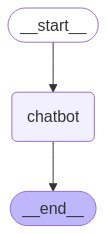

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [11]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  


User: What do you know about LangGraph?
Assistant: LangGraph is a library developed by LangChain that allows you to create and manage stateful, multi-actor computational graphs for building complex AI workflows and agents. Here are some key details:

1. Purpose:
- Enables creation of cyclical and more complex AI workflows
- Allows for persistent state management between agent steps
- Supports building agent systems with multiple actors or components

2. Key Features:
- Stateful computational graphs
- Cycle-enabled graph structure
- Ability to create branching and converging workflows
- Integration with LangChain's ecosystem
- Support for custom state management

3. Use Cases:
- Multi-agent systems
- Complex reasoning workflows
- Interactive AI assistants
- Collaborative problem-solving scenarios

4. Technical Characteristics:
- Built on top of NetworkX for graph management
- Allows for custom state transitions
- Supports different types of nodes and edges
- Enables programmatic control

## Part 2: 🛠️ Enhancing the Chatbot with Tools

In [12]:
# %%capture --no-stderr
# %pip install -U tavily-python langchain_community

In [13]:
_set_env("TAVILY_API_KEY")

In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).\nSimilar to NetworkX, you add these nodes to a graph using the add_node method:\n[](https://langchain-ai.github.io/langgraph/concepts/low_level/#__codelineno-7-1)from langchain_core.runnables import RunnableConfig [...] By composing Nodes and Edges, you can create complex, looping workflows that evolve the State over time. The real power, though, comes from how LangGraph manages that State. To emphasize: Nodes and Edges are nothing more than Python functions - they can contain an LLM or just good ol\' Python code.\nIn short: nodes do the work. edges tell what to do next. [...] Nodes: Python functions that enco

In [15]:
from typing import Annotated
from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatAnthropic(model=MODEL_CLAUDE)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [16]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [17]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

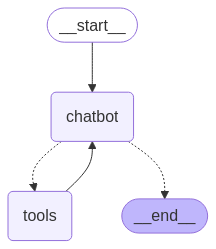

In [18]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [19]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  


User: What do you know about LangGraph?
Assistant: [{'text': 'Let me search for some up-to-date information about LangGraph.', 'type': 'text'}, {'id': 'toolu_01Y6qmcQtvqvV7XsJs9FbSHi', 'input': {'query': 'LangGraph library LangChain AI development framework'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for developing more complex, [...] solution ...\"}, {\"url\": \"h

## Part 3: Adding Memory to the Chatbot

In [20]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [21]:
from typing import Annotated
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatAnthropic(model=MODEL_CLAUDE)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [22]:
graph = graph_builder.compile(checkpointer=memory)

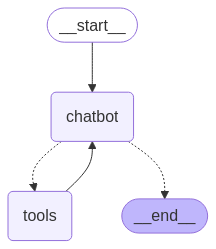

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
config = {"configurable": {"thread_id": "1"}}

In [25]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! It's nice to meet you. I'm an AI assistant ready to help you with any questions or tasks you might have. Is there anything specific I can help you with today?


In [26]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, Will! I'll remember your name during our conversation. Is there something I can help you with today?


In [27]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I apologize, but I do not have the ability to remember your name from previous conversations. Each interaction starts fresh, and I do not retain personal information between chat sessions. If you'd like, you can tell me your name in this conversation, and I'll be happy to address you by it during our current interaction.


In [28]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='b7fc9f3d-e2d2-4395-aa87-4086ef3a9534'), AIMessage(content="Hello Will! It's nice to meet you. I'm an AI assistant ready to help you with any questions or tasks you might have. Is there anything specific I can help you with today?", additional_kwargs={}, response_metadata={'id': 'msg_014Hoi41tcYtpT3SFVXVV8hJ', 'model': 'claude-3-5-haiku-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 375, 'output_tokens': 42}, 'model_name': 'claude-3-5-haiku-20241022'}, id='run-299eac50-ff6f-47e9-a5e2-e8512780f773-0', usage_metadata={'input_tokens': 375, 'output_tokens': 42, 'total_tokens': 417, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='e31683d4-ce0e-43f9-929d

In [29]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

## Part 4: Human-in-the-loop

In [30]:
from typing import Annotated
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatAnthropic(model=MODEL_CLAUDE)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [31]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

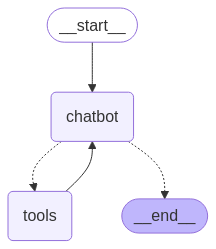

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [33]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'text': "I'll help you request human assistance for guidance on building an AI agent.", 'type': 'text'}, {'id': 'toolu_0166RWBsuD67CL9koQhGsZ91', 'input': {'query': "I'm looking for expert guidance on building an AI agent. Could you provide insights on:\n1. Best practices for AI agent design\n2. Key considerations for agent architecture\n3. Recommended technologies and frameworks\n4. Potential challenges and how to overcome them\n5. Advice on ensuring the agent's reliability and performance\n\nWhat specific recommendations would you have for someone looking to develop an advanced AI agent?"}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_0166RWBsuD67CL9koQhGsZ91)
 Call ID: toolu_0166RWBsuD67CL

In [34]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [35]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "I'll help you request human assistance for guidance on building an AI agent.", 'type': 'text'}, {'id': 'toolu_0166RWBsuD67CL9koQhGsZ91', 'input': {'query': "I'm looking for expert guidance on building an AI agent. Could you provide insights on:\n1. Best practices for AI agent design\n2. Key considerations for agent architecture\n3. Recommended technologies and frameworks\n4. Potential challenges and how to overcome them\n5. Advice on ensuring the agent's reliability and performance\n\nWhat specific recommendations would you have for someone looking to develop an advanced AI agent?"}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_0166RWBsuD67CL9koQhGsZ91)
 Call ID: toolu_0166RWBsuD67CL9koQhGsZ91
  Args:
    query: I'm looking for expert guidance on building an AI agent. Could you provide insights on:
1. Best practices for AI agent design
2. Key considerat

## Part 5: Customizing State

In [36]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [37]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.types import Command, interrupt

@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [38]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [39]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================

[{'text': "Certainly! I'll start by searching for information about LangGraph's release date using the Tavily search engine, and then I'll use the human_assistance tool for review. Let's begin with the search.", 'type': 'text'}, {'id': 'toolu_012gbEeurSuPqNcD3NDqYSJg', 'input': {'query': 'LangGraph release date'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_012gbEeurSuPqNcD3NDqYSJg)
 Call ID: toolu_012gbEeurSuPqNcD3NDqYSJg
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "langgraph - PyPI", "url": "https://pypi.org/project/langgraph/0.

In [40]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'text': "Based on the search results, I can provide information about LangGraph's release. The earliest version of LangGraph that I can find in the release history is version 0.0.8, which was released on January 7, 2024. This appears to be the initial public release of LangGraph.\n\nNow, let's use the human_assistance tool to review this information. For this, we need to provide a name and birthday. Since we don't have specific information about the reviewer, I'll use placeholder information.", 'type': 'text'}, {'id': 'toolu_01FyscUWszUogGfmhCDqqNR2', 'input': {'name': 'Reviewer', 'birthday': '1990-01-01'}, 'name': 'human_assistance', 'type': 'tool_use'}]
Tool Calls:
  human_assistance (toolu_01FyscUWszUogGfmhCDqqNR2)
 Call ID: toolu_01FyscUWszUogGfmhCDqqNR2
  Args:
    name: Reviewer
    birthday: 1990-01-01
================================= Tool Message =================================
Name: human_as

In [41]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

In [42]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f009787-222b-6ba2-8006-c1a8ed1c1d9c'}}

In [43]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

## Part 6: Time Travel

In [44]:
from typing import Annotated
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
# llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm = ChatAnthropic(model=MODEL_CLAUDE)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [45]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "I'll search for some information about LangGraph to help you learn more about it.", 'type': 'text'}, {'id': 'toolu_01WTuhu6CuDSnFvK62vqMFB6', 'input': {'query': 'LangGraph library LangChain AI framework explanation'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01WTuhu6CuDSnFvK62vqMFB6)
 Call ID: toolu_01WTuhu6CuDSnFvK62vqMFB6
  Args:
    query: LangGraph library LangChain AI framework explanation
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Complete Guide to Building LangChain Agents with the LangGraph ...", "url": "https://www.getzep.com/ai-agents/langchain-agents-langgraph", "content": "| Overview of Lang

In [46]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

[{'text': 'Let me search for some guidance on building an autonomous agent with LangGraph to give you some practical insights.', 'type': 'text'}, {'id': 'toolu_017WkDLuUUqh2KmHMo2MXkJY', 'input': {'query': 'How to build an autonomous agent using LangGraph step-by-step tutorial'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_017WkDLuUUqh2KmHMo2MXkJY)
 Call ID: toolu_017WkDLuUUqh2KmHMo2MXkJY
  Args:
    query: How to build an autonomous agent using LangGraph step-by-step tutorial
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "How to Build AI Agents Step-by-Step with LangGraph - Medium", "url": "https://medium.com/data-scien

In [47]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  12 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  11 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  10 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  9 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  8 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------

In [48]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f009788-ba09-67a5-8005-47a7fb460d1b'}}


In [49]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Based on the research, here's a comprehensive overview of LangGraph:

1. What is LangGraph?
LangGraph is a powerful library developed by LangChain that extends the capabilities of language model (LLM) workflows by providing advanced state management and graph-based orchestration for AI agents.

2. Key Features:
- State Management: Allows developers to define, manage, and transition between different states in AI workflows
- Graph-based Orchestration: Uses state graphs with nodes and conditional edges to model agent interactions
- Multi-Agent Coordination: Enables complex, stateful applications with multiple AI actors
- Granular Control: Provides detailed control over an agent's thought process and decision-making

3. How It Works:
- State Graph Structure: Composed of nodes representing different states
- Conditional Edges: Define transitions between states based on specific conditions
- Persistent State: 